# Capstone Project - The Battle of the Neighborhoods


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

I have just received an offer from a Toronto-based firm that requires Relocation.  The position is comparable along with salary and benefits, so the primary considerations for me lifestyle changes.  I would like to evaluate the new city in comparison to my hometown New York, and determine if the two cities are substantially similar or significantly different.  Second, I would like to find the neighborhood that most closely matches the one where I currently reside in Brooklyn. 

For clarity, neighborhoods are defined in a [separate notebook](https://github.com/jshubin-ghub/coursera-capstone-project/blob/master/Capstone_Week_Five_Neighborhoods.ipynb).  Neighborhoods were defined by a 1km radius circle around the geocordinates for individual postal codes in each city.  A few postal codes were removed due to overlap, see the above notebook for details.  This definition matched my need for the neighborhood to be 'walkable.'  Most venues would be no more than a 15 minute walk from the center of the neighborhood.

## Data <a name="data"></a>

Data Collection for this project was quite involved, due to limitations and sparse documentation of the FourSquare API.  After some experimentation, I was able to determine the search parameters that retieved the greatest number of venues per search, which was using the search endpoint with the parameter 'intent' set to 'browse'.  One drawback of this search strategy was that it was often capped due to limits on the number of venues returned by a single search.  
To accomodate this a multipoint search pattern was developed for each neighborhood.  This approach, in turn exceeded the daily search quota for unregistered API keys, which meant that a means to retrieve and combine data from mulitple searches was needed.  The details of the search patterns and data retrieval are found in a [separate notebook](https://github.com/jshubin-ghub/coursera-capstone-project/blob/master/Capstone_Week_Five_Data_Collection.ipynb).
Lastly, venue records were removed if they were incomplete or if the venue locations were outside of the defined limits of the neighborhood.  

In [8]:
import pickle
import pandas as pd

# retrieve neighborhood venues from new york

try:
    with open('ny_cleaned_results.pkl', 'rb') as handle:
        ny_cleaned_results = pickle.load(handle)
        print('loading ny_cleaned_results from filesystem')
except Exception as e: 
    print("Exception caught: {}".format(e))  

try:
    with open('toronto_cleaned_results.pkl', 'rb') as handle:
        toronto_cleaned_results = pickle.load(handle)
        print('loading toronto_cleaned_results from filesystem')
except Exception as e: 
    print("Exception caught: {}".format(e))

venues = 0
for neighborhood in ny_cleaned_results:
    this_neighborhood = ny_cleaned_results[neighborhood]
    venues += (len(this_neighborhood))
print ('New York Venue Count:', venues)
venues = 0
for neighborhood in toronto_cleaned_results:
    this_neighborhood = toronto_cleaned_results[neighborhood]
    venues += (len(this_neighborhood))
print ('Toronto Venue Count:', venues)

loading ny_cleaned_results from filesystem
loading toronto_cleaned_results from filesystem
New York Venue Count: 140227
Toronto Venue Count: 71040


### Category Data

Category data for venues provided too many unique values for feature coding of the data.  Each neighborhood would have been essentially unique, and positioned far from all other neighborhoods in the data space.  To create more comparable neighborhoods, each category venue was matched with their top-level category (of which there were  10).  The code used to gather the category data and match each category to a top-level category is found in a [separate notebook](https://github.com/jshubin-ghub/coursera-capstone-project/blob/master/Capstone_Week_Five_Categories.ipynb).  

In [9]:
# retrieve category dict
# updated for new version of category dataframe with top parent categories


try:
    with open('full_categories_df.pkl', 'rb') as handle:
        full_categories_df = pickle.load(handle)
        print('loading full_categories_df from filesystem')
except Exception as e: 
    print("Exception caught: {}".format(e))  

loading full_categories_df from filesystem


### Data  Engineering

Categories are matched to their top level venue categories, and then aggregated for all neighborhoods.

In [10]:
# add ultimate parent category_id for each venue in New York neighborhoods

ny_complete_results = {}
for postcode in ny_cleaned_results:
    a_new_df = pd.DataFrame(ny_cleaned_results[postcode])
    merged_df = pd.merge(a_new_df, full_categories_df, left_on='new_category', right_on='category_id', how='left')
    ny_complete_results[postcode]= merged_df

In [22]:
# count the venues of each top-level category type in each neighborhood dataframe

ny_grouped_df = pd.DataFrame(columns = ['PostCode', 'category_id', 'category_name', 'count'])
for postcode in ny_complete_results:
    check_df = ny_complete_results[postcode]
    grouped = check_df.groupby('top_parent_id')
    for item in grouped:
        cat_id = item[0]
        cat_name = full_categories_df.loc[full_categories_df['category_id']==cat_id]['category_name']
        cat_name.reset_index(drop=True, inplace=True)
        new_row = [postcode, item[0], cat_name[0], len(item[1])]
        new_row_df = pd.DataFrame([new_row], columns = ['PostCode', 'category_id', 'category_name', 'count'])
        ny_grouped_df = ny_grouped_df.append(new_row_df, ignore_index=True)
ny_grouped_df.head()

,PostCode,category_id,category_name,count
0,10453,4d4b7104d754a06370d81259,Arts & Entertainment,4
1,10453,4d4b7105d754a06372d81259,College & University,66
2,10453,4d4b7105d754a06374d81259,Food,172
3,10453,4d4b7105d754a06375d81259,Professional & Other Places,173
4,10453,4d4b7105d754a06376d81259,Nightlife Spot,16


In [33]:
# add an attribute to each postal code (neighborhood) indicating the city where it is found (1=New York)
city_label_df = pd.DataFrame(columns = ['city'])
city_label_df['PostCode'] = ny_grouped_df.PostCode.unique()
city_label_df['city'] = 1
city_label_df.tail()

,city,PostCode
166,1,10312
167,1,10301
168,1,10304
169,1,10305
170,1,10314


In [13]:
# add ultimate parent category_id to Tonronto Neighborhoods

toronto_complete_results = {}
for postcode in toronto_cleaned_results:
    a_new_df = pd.DataFrame(toronto_cleaned_results[postcode])
    merged_df = pd.merge(a_new_df, full_categories_df, left_on='new_category', right_on='category_id', how='left')
    toronto_complete_results[postcode]= merged_df

In [23]:
toronto_grouped_df = pd.DataFrame(columns = ['PostCode', 'category_id', 'category_name', 'count'])
for postcode in toronto_complete_results:
    check_df = toronto_complete_results[postcode]
    grouped = check_df.groupby('top_parent_id')
    for item in grouped:
        cat_id = item[0]
        cat_name = full_categories_df.loc[full_categories_df['category_id']==cat_id]['category_name']
        cat_name.reset_index(drop=True, inplace=True)
        new_row = [postcode, item[0], cat_name[0], len(item[1])]
        new_row_df = pd.DataFrame([new_row], columns = ['PostCode', 'category_id', 'category_name', 'count'])
        toronto_grouped_df = toronto_grouped_df.append(new_row_df, ignore_index=True)
toronto_grouped_df.head()

,PostCode,category_id,category_name,count
0,M3A,4d4b7104d754a06370d81259,Arts & Entertainment,5
1,M3A,4d4b7105d754a06372d81259,College & University,11
2,M3A,4d4b7105d754a06374d81259,Food,57
3,M3A,4d4b7105d754a06375d81259,Professional & Other Places,146
4,M3A,4d4b7105d754a06376d81259,Nightlife Spot,9


In [34]:
city_label_df_add = pd.DataFrame(columns = ['city'])
city_label_df_add['PostCode'] = toronto_grouped_df.PostCode.unique()
city_label_df_add['city'] = 0

In [36]:
print(len(city_label_df['PostCode']))
city_label_df = city_label_df.append(city_label_df_add, ignore_index=True)
city_label_df.tail()

171


,city,PostCode
265,0,M8X
266,0,M4Y
267,0,M7Y
268,0,M8Y
269,0,M8Z


In [37]:
toronto_data = toronto_grouped_df.pivot(index = 'PostCode', columns = 'category_name', values = 'count')
ny_data = ny_grouped_df.pivot(index = 'PostCode', columns = 'category_name', values = 'count')
all_data = toronto_data.append(ny_data)
all_data

category_name,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
PostCode,,,,,,,,,,
M1B,5,6,NaN,123,4,52,210,NaN,257,25
M1C,27,14,NaN,68,14,25,84,19,152,28
M1E,NaN,3,NaN,138,11,45,151,53,307,82
M1G,7,NaN,NaN,109,7,21,73,16,88,25
M1H,9,17,NaN,130,11,77,242,19,231,23
...,...,...,...,...,...,...,...,...,...,...
11691,25,16,NaN,125,16,82,214,22,177,57
11692,6,NaN,NaN,102,3,114,177,41,119,138
11693,17,NaN,NaN,148,33,86,131,37,185,52


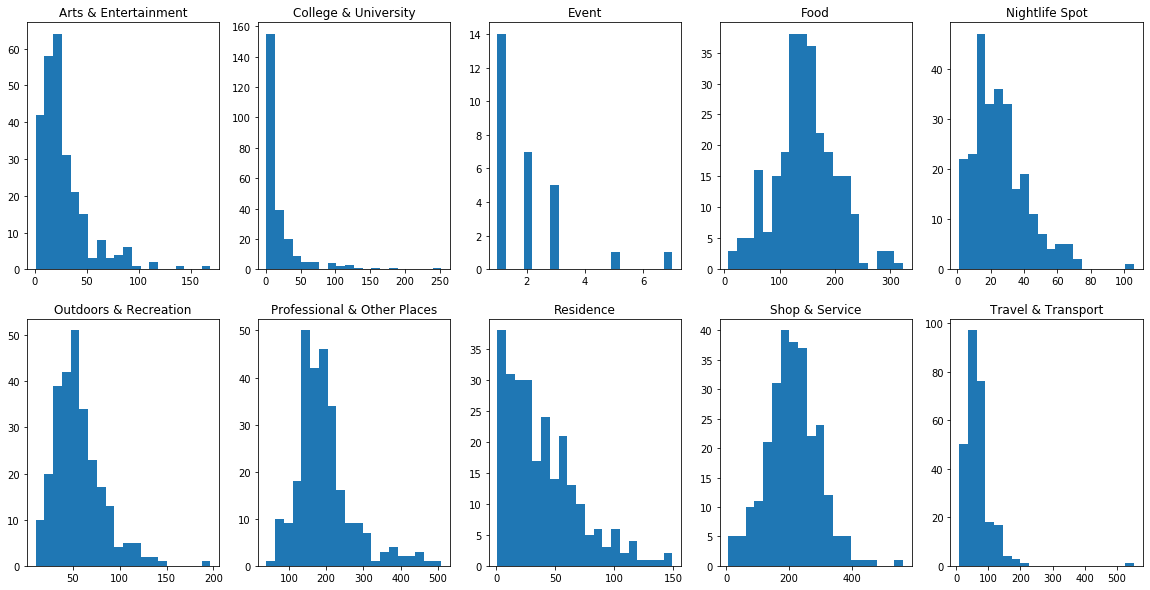

In [38]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize = (20, 10))
plot_num = 0
for column in all_data.columns:
    axs[plot_num//5,plot_num-(5*(plot_num//5))].hist(all_data[column],bins=20)
    axs[plot_num//5,plot_num-(5*(plot_num//5))].set_title(column)
#     this_plot.set_label(column)
    plot_num += 1
plt.savefig('category_histograms.png')
plt.show()

In [39]:
# Event category is dropped, and NaN values changed to Zero

selected_data = all_data.drop(columns=['Event'])
selected_data.fillna(value=0, inplace = True)

## Methodology<a name="methodology"></a>

The first step conducted in the analysis was to explore similarities and differences in the neighborhoods.  This was conducted in two contexts. The first was a casual clustering to determine if New York Neighborhoods differed significantly, in general, from Toronto Neighborhoods.  This was done by dividing all Neighborhoods into two clusters, and determining if these clusters tended to segregate the nieghborhoods into separate clusters. 

In [42]:
import numpy as np
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(selected_data)
y_kmeans = kmeans.predict(selected_data)
print('there are ', len(y_kmeans), ' neighborhoods')
print(y_kmeans.sum(), 'are in one cluster')
print(np.count_nonzero(y_kmeans == 0), 'are in the other cluster')

city_label_df['cluster']=y_kmeans
city_label_df
print('NY neighborhoods in Cluster 0:',
      np.logical_and(city_label_df['city']==1 , city_label_df['cluster']==0).sum())
print('NY neighborhoods in Cluster 1:',
      np.logical_and(city_label_df['city']==1 , city_label_df['cluster']==1).sum())
print('Toronto neighborhoods in Cluster 0:',
      np.logical_and(city_label_df['city']==0 , city_label_df['cluster']==0).sum())
print('Toronto neighborhoods in Cluster 1:',
      np.logical_and(city_label_df['city']==0 , city_label_df['cluster']==1).sum())

there are  270  neighborhoods
188 are in one cluster
82 are in the other cluster
NY neighborhoods in Cluster 0: 64
NY neighborhoods in Cluster 1: 107
Toronto neighborhoods in Cluster 0: 18
Toronto neighborhoods in Cluster 1: 81


This result yeilds a chi-squared test statistic of 4.8, suggesting neighborhoods for the two cities are, on the whole, different at a 0.05 confidence interval.  Determining the exact nature of this difference, which is probably due to either differing venue density or venue category mix within the different cities' neighborhoods, is beyond the scope of this study.  For the purposes of the relocation, the key understanding is that relocating to a similar neighborhood is less likely to happen by chance, supporting a data-driven approach to the task is likely to lead to a better outcome.

In [44]:
# normalize selected_data
# with mean = 0 and std_dev = 1 
# scaled data is in the dataframe df_all

from sklearn import preprocessing
import numpy as np
X_index =  selected_data.index
X_columns = selected_data.columns
X = selected_data.values # returns a numpy array
X_scaled = preprocessing.scale(X)

# convert numpy array back to a dataframe
df = pd.DataFrame(X_scaled)
df.columns = X_columns
df_all=df.set_index(X_index)

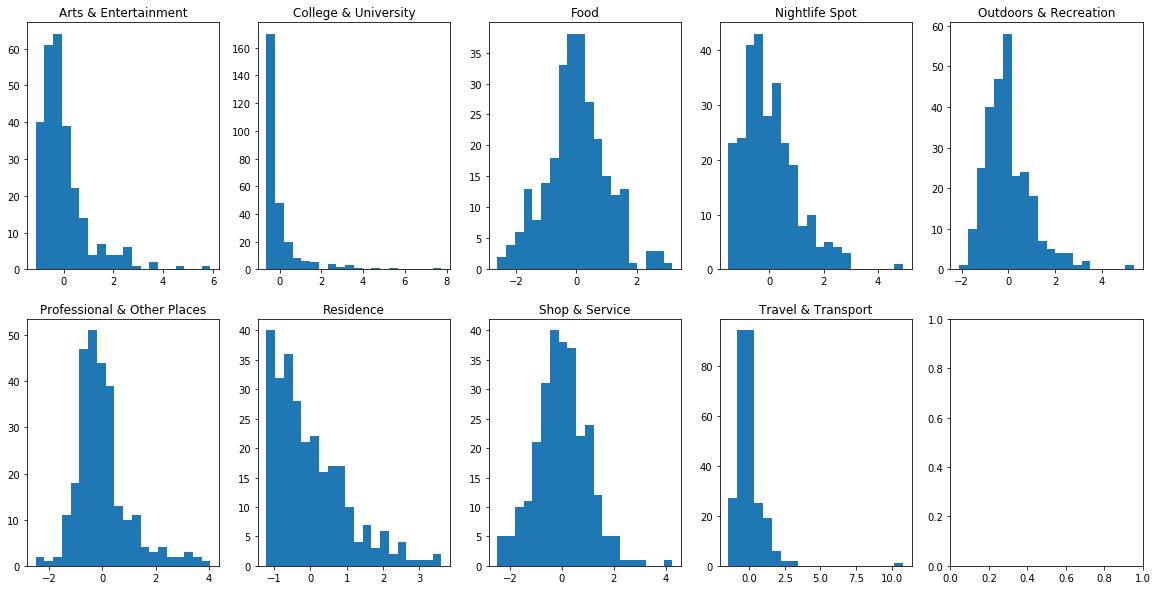

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize = (20, 10))
plot_num = 0
for column in df_all.columns:
    axs[plot_num//5,plot_num-(5*(plot_num//5))].hist(df_all[column],bins=20)
    axs[plot_num//5,plot_num-(5*(plot_num//5))].set_title(column)
#     this_plot.set_label(column)
    plot_num += 1
plt.savefig('category_histograms.png')
plt.show()

In [ ]:
#Normalized Data is saved to a pickle file

df_all.to_pickle("all_data_normalized.pkl")
city_label_df.to_pickle("city_label.pkl")

### PCA analysis (mosty for visualization)

A 2 dimensional representation of the data is created to aid in visualizing clusters produced. The two components resulting from the analysis accounted for 45% of the variation in samples.   A plot of the resulting 2d projection with points color-coded by city, and a plot of the contribution vector for each feature is produced.

In [51]:
#Principle Component Analysis to explore the data
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
projected = pca.fit_transform(df_all)
print(df_all.shape)
print(projected.shape)


(270, 9)
(270, 2)


In [52]:
print(pca.explained_variance_)
print(np.cumsum((pca.explained_variance_ratio_)))

[2.17911603 1.9255875 ]
[0.24122725 0.45438899]


Text(0, 0.5, 'second component')

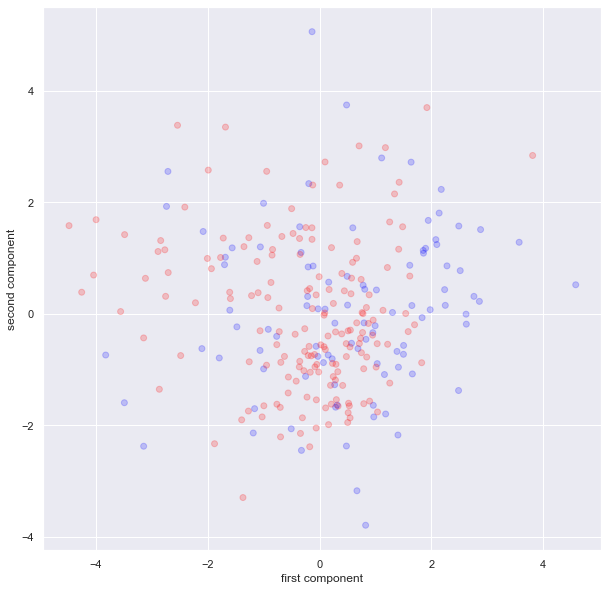

In [54]:
city=pd.DataFrame() 
for index,row in df_all.iterrows():
    city.at[index,'postcode']=row.name
    if len(row.name)==5:
        city.at[index,'ny']='red' # new york neighborhoods are red
    else: 
        city.at[index,'ny']='blue'
plt.figure(figsize=(10,10)) 
plt.scatter(projected[:,0],projected[:,1],
            c = city['ny'],
            alpha = 0.2
           )
# for i, txt in enumerate(city['postcode']):
#     plt.annotate(txt, (projected[i,0], projected[i,1]))
plt.xlabel('first component')
plt.ylabel('second component')


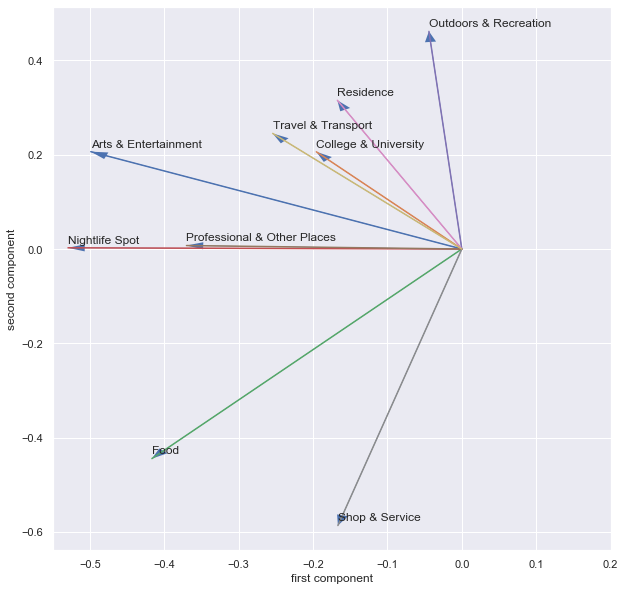

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
for i in range(len(pca.components_[0])):
    ax.plot([0,pca.components_[0][i]],[0,pca.components_[1][i]])
    ax.arrow(0,0,pca.components_[0][i],pca.components_[1][i], shape='full', lw=0, length_includes_head=True, head_width=.015)
    ax.annotate(df_all.columns[i], (pca.components_[0][i], pca.components_[1][i]+0.01))
    ax.set_xlim(-0.55, 0.2) 
#plt.plot(x_values, y_values)

plt.xlabel('first component')
plt.ylabel('second component')
plt.savefig('arrow_plot.png')
plt.show()

## Analysis<a name="analysis"></a>

Cluster analysis was performed to determine the nighborhoods in Toronto that would be grouped with the home neighborhood (ZIPCode 11104).  Data was first analyzed to determine the appropriate number of clusters, first using a dendrogram hierarchical clustering, and then evaluating using the elbow method.  A range of clustering with 3 <= k <= 5 were proudced for comparitive purposes.

A map of all neighborhoods clustered with the home Nieghborhood using k = 5 highlights the limitations of this approach, showing too may neighborhood as similar to the home cluster and therefore viable candidates for relocation.  At best this could be used a means to exclude opportunities not in viable neighborhoods, and did not provide a selective enough set of candidates to limit the scope of the search to a managable number of neighborhoods.

To provide an ordered list of candidates, an analysis of n-dimension feature distance was calculated from the home neighborhood to every other neighborhood.  This was then visuallized in a plot that showed the neighborhoods that we feature-distance closest to the home neighborhood in bright colors, and neighborhoods with greater feature-distances in darker shades.  This result provided a limited number of neighborhoods as candidates, and provides a basis for conducting a real world search. 

### Cluster Analysis

After evaluating the data with a hierachical clustering algorithm that suggested 5 clusters were a good choice for the dataset, and a plot using the elbow method suggested 4 clusters, neighborhoods were clustered with the k-means algorithm.  Ultimately clusters for k = 3, 4, and 5 were created, and the results of the 5 cluster result was mapped onto the city of toronto.  In each plot, the cluster with the home neighborhood (ZIPCode 11104) was plotted in red. We can see from the map of the neighborhoods within the same cluster as the home neighborhood remiained prohibitively large.  

In [81]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

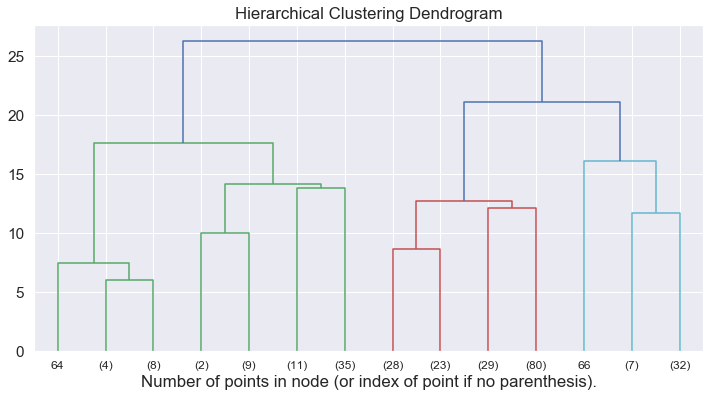

In [82]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_all)
plt.figure(figsize = (12,6))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig('dendrogram.png')
plt.show()

If we set the distance threshold to ~15, 5 clusters will be produced. 
This plot might suggest that the data at location 66 is an outlier. 

In [58]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_all)
    Sum_of_squared_distances.append(km.inertia_)

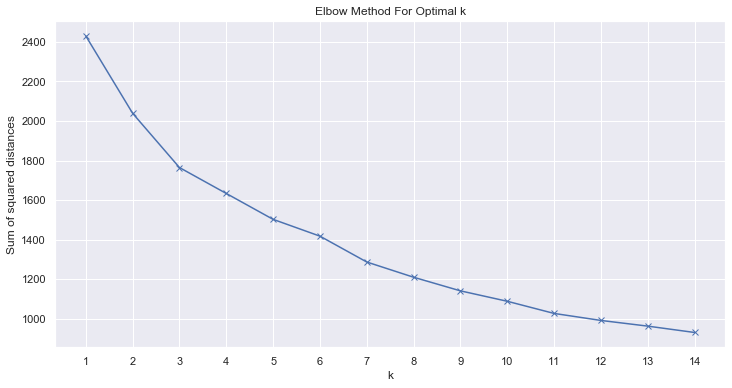

In [59]:
plt.figure(figsize=(12,6))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.savefig('Elbow Plot for Neighborhood Data')
plt.xticks(ticks=K)
plt.show()

From the above graph it appears that optimal k = 4.  K-Means clusters were produced for k = 3, 4, and 5 for comparison.

In [63]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_all)
y_kmeans_three = kmeans.predict(df_all)
unique, counts = np.unique(y_kmeans_three, return_counts=True)
dict(zip(unique, counts))

{0: 141, 1: 80, 2: 49}

In [64]:
colors = ['red','green', 'blue']
city=pd.DataFrame()
for count, row in enumerate(df_all.iterrows()):
    city.at[count,'postcode']=row[0]
    this_color = y_kmeans_three[count]
    city.at[count,'color']=colors[this_color]
    if row[0][0]=='M':
        city.at[count,'outline']='none'
    else:
        city.at[count,'outline']='black'

In [65]:
city.loc[city.postcode.eq('11104')]

,postcode,color,outline
178,11104,red,black


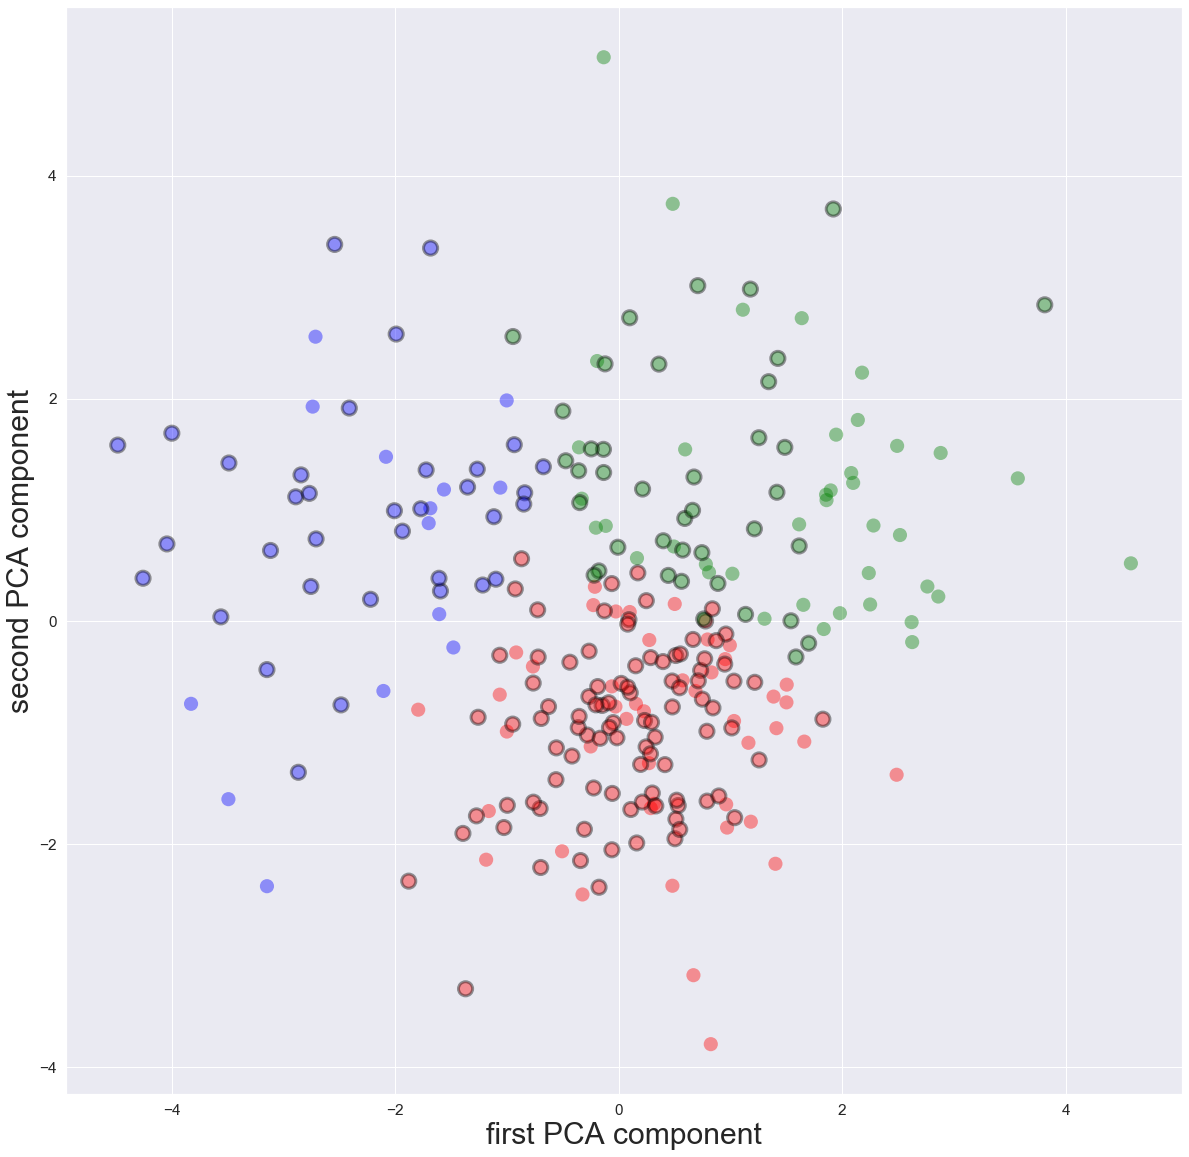

In [66]:
import seaborn as sns
sns.set(font_scale = 1.4)
plt.figure(figsize=(20,20)) 
plt.scatter(projected[:,0],projected[:,1],
            c = city['color'],
            alpha = 0.4,
            edgecolors = city['outline'],
            linewidths = 3,
            s = 200,
            
           )
# for i, txt in enumerate(city['postcode']):
#     plt.annotate(txt, (projected[i,0], projected[i,1]))
plt.xlabel('first PCA component', fontsize=30)
plt.ylabel('second PCA component', fontsize=30)
plt.savefig('3_clusters.png')

In [67]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_all)
y_kmeans_four = kmeans.predict(df_all)
unique, counts = np.unique(y_kmeans_four, return_counts=True)
dict(zip(unique, counts))

{0: 62, 1: 42, 2: 132, 3: 34}

In [68]:
colors = ['blue','green','red','yellow']
city=pd.DataFrame()
for count, row in enumerate(df_all.iterrows()):
    city.at[count,'postcode']=row[0]
    this_color = y_kmeans_four[count]
    city.at[count,'color']=colors[this_color]
    if row[0][0]=='M':
        city.at[count,'outline']='none'
    else:
        city.at[count,'outline']='black'

In [69]:
city.loc[city.postcode.eq('11104')]

,postcode,color,outline
178,11104,red,black


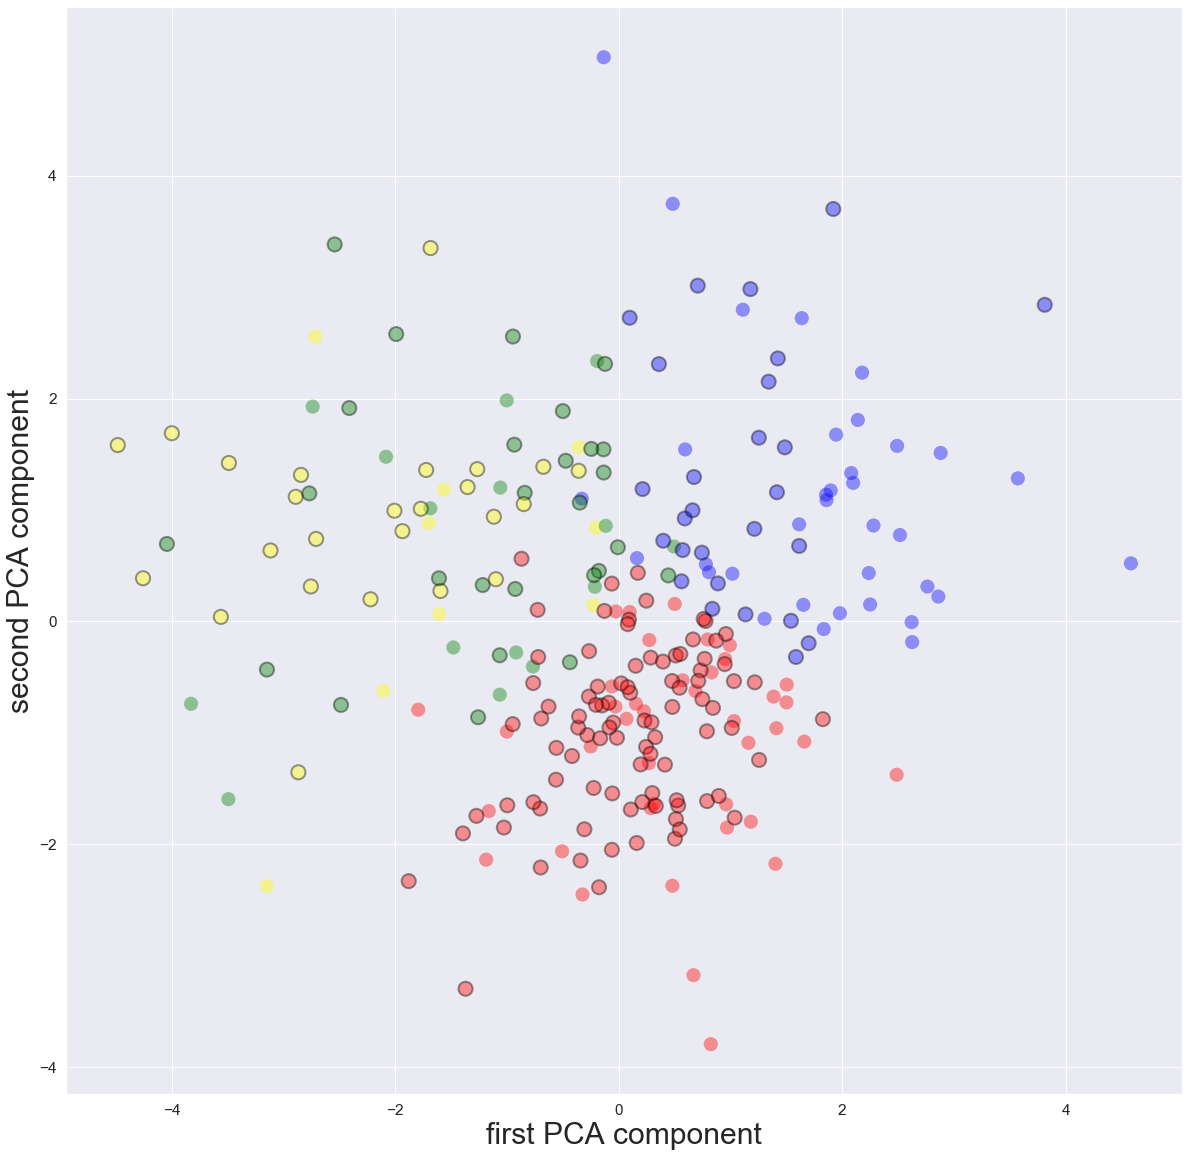

In [70]:
import seaborn as sns
sns.set(font_scale = 1.4)

plt.figure(figsize=(20,20)) 
plt.scatter(projected[:,0],projected[:,1],
            c = city['color'],
            alpha = 0.4,
            edgecolors = city['outline'],
            linewidths = 2,
            s = 200,
            
           )
# for i, txt in enumerate(city['postcode']):
#     plt.annotate(txt, (projected[i,0], projected[i,1]))
plt.xlabel('first PCA component', fontsize=30)
plt.ylabel('second PCA component', fontsize=30)
plt.savefig('4_clusters.png')

In [71]:
kmeans_five = KMeans(n_clusters=5, random_state=0).fit(df_all)
y_kmeans_five = kmeans_five.predict(df_all)
type(y_kmeans_five)
unique, counts = np.unique(y_kmeans_five, return_counts=True)
dict(zip(unique, counts))

{0: 79, 1: 126, 2: 15, 3: 1, 4: 49}

In [72]:
colors = ['green','red', 'blue', 'purple', 'yellow']
city=pd.DataFrame()
for count, row in enumerate(df_all.iterrows()):
    city.at[count,'postcode']=row[0]
    this_color = y_kmeans_five[count]
    city.at[count,'color']=colors[this_color]
    if row[0][0]=='M':
        city.at[count,'outline']='none'
    else:
        city.at[count,'outline']='black'

In [73]:
city.loc[city.postcode.eq('11104')]

,postcode,color,outline
178,11104,red,black


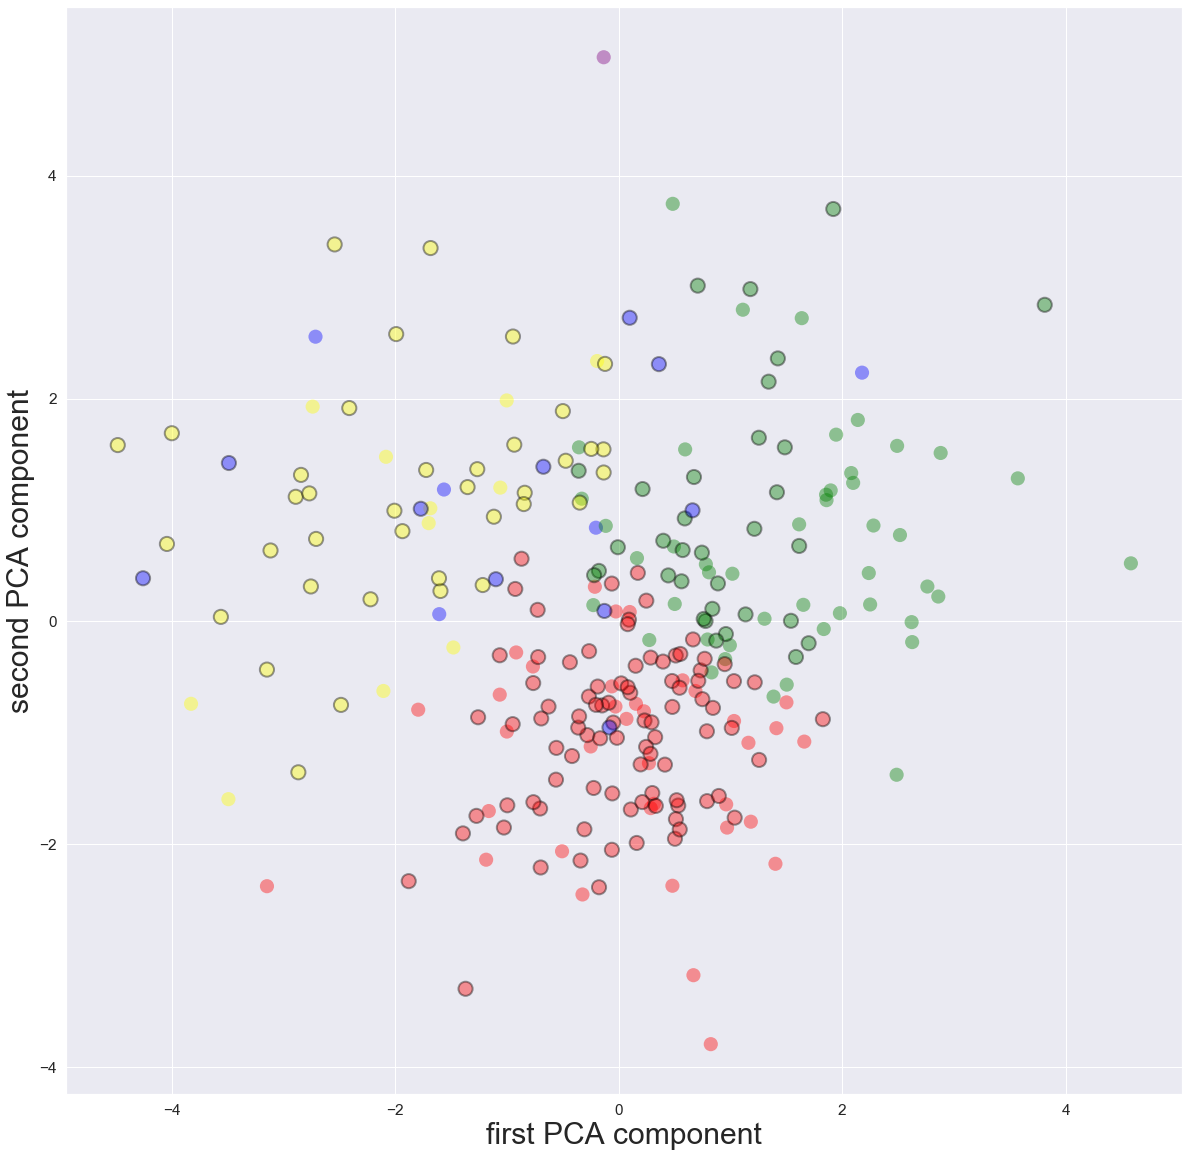

In [74]:
import seaborn as sns
sns.set(font_scale = 1.4)
plt.figure(figsize=(20,20)) 
plt.scatter(projected[:,0],projected[:,1],
            c = city['color'],
            alpha = 0.4,
            edgecolors = city['outline'],
            linewidths = 2,
            s = 200,
            
           )
# for i, txt in enumerate(city['postcode']):
#     plt.annotate(txt, (projected[i,0], projected[i,1]))
plt.xlabel('first PCA component', fontsize=30)
plt.ylabel('second PCA component', fontsize=30)
plt.savefig('5_clusters.png')

In [75]:
colors = ['grey','yellow','grey','grey','grey']
city=pd.DataFrame()
for count, row in enumerate(df_all.iterrows()):
    city.at[count,'postcode']=row[0]
    this_color = y_kmeans_five[count]
    city.at[count,'color']=colors[this_color]
    if row[0][0]=='M':
        city.at[count,'outline']='none'
    else:
        city.at[count,'outline']='black'
city.set_index(city['postcode'], inplace = True)


In [76]:
try:
    with open('all_geodata.pkl', 'rb') as handle:
        all_geodata_df = pickle.load(handle)
        print('all_geodata_df from filesystem')
except Exception as e: 
    print("Exception caught: {}".format(e))
map_data = pd.concat([city, all_geodata_df], axis = 1, sort = False)
map_data.dropna(inplace=True)
map_data

all_geodata_df from filesystem


,postcode,color,outline,Latitude,Longitude
M1B,M1B,yellow,none,43.806686,-79.194353
M1C,M1C,grey,none,43.784535,-79.160497
M1E,M1E,yellow,none,43.763573,-79.188711
M1G,M1G,grey,none,43.770992,-79.216917
M1H,M1H,grey,none,43.773136,-79.239476
...,...,...,...,...,...
11691,11691,grey,black,40.601278,-73.761651
11692,11692,grey,black,40.594095,-73.792896
11693,11693,grey,black,40.590692,-73.809749
11694,11694,grey,black,40.578270,-73.844762


In [77]:
in_cluster, outof_cluster = 0,0
for namedTuple in map_data.itertuples():
    row_dict = namedTuple._asdict()
    # Toronto neighborhoods have 'none' in outline column
    if row_dict['outline']=='none':
        if row_dict['color']=='yellow':
            in_cluster += 1
        else:
            outof_cluster +=1
print(in_cluster, 'neighborhoods share the same cluster as 11104')
print('Ratio of neighborhoods in same cluster as ZIPCode 11104:', in_cluster/(in_cluster+outof_cluster))
            
# for row in map_data.iterrows():
#     for item in row:
#         print(item)
#         for it in item:
#     break

36 neighborhoods share the same cluster as 11104
Ratio of neighborhoods in same cluster as ZIPCode 11104: 0.36363636363636365


In [78]:
import folium


#import branca
#import branca.colormap as cm

#color_map = cm.get_cmap('viridis', 12)
#color_map = cm.get_cmap('RdYlGn')
#color_map = cm.get_cmap('Greys')
latitude, longitude  = 43.718518, -79.464763 # center map in Toronto 
postal_zone_map = folium.Map(location=[latitude, longitude], zoom_start=11) 
for latitude, longitude, color, label in zip(map_data['Latitude'], 
                                               map_data['Longitude'],
                                               map_data['color'],
                                               map_data.index):
    folium.vector_layers.CircleMarker(
        [latitude, longitude],
        radius=7,
        color='black',
        #popup=label1 + '\n'+ label2,
        popup = label,        
        fill_color=color,
        fill_opacity=100,
        fill = True
    ).add_to(postal_zone_map)
# display map

postal_zone_map.save('distance_map.html')
postal_zone_map

### Cluster performance analysis

Evaluation of the quality of these clusters using the silhouette coefficient suggests that these clusters do not have a solid basis in the variation of our neighborhood data.

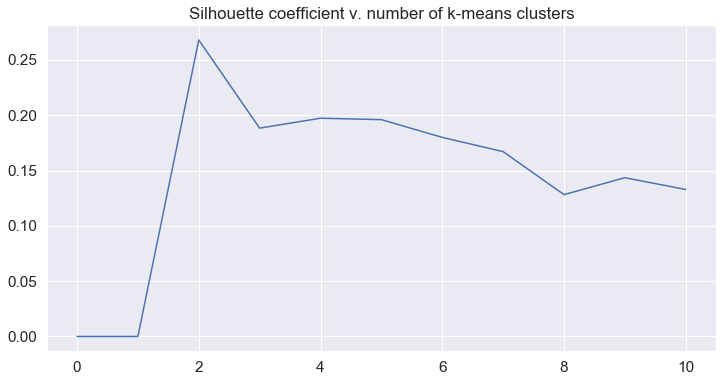

In [84]:
from sklearn.metrics import silhouette_score

sil = [0,0]
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(df_all)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_all, labels, metric = 'euclidean'))

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(sil)
ax.set_title('Silhouette coefficient v. number of k-means clusters')
plt.savefig('silhouette.png')


### Guidelines for results of average Silhouette Coefficient
**0.71-1.0**
A strong structure has been found

**0.51-0.70**
A reasonable structure has been found

**0.26-0.50**
The structure is weak and could be artificial. Try additional methods of data analysis.

**< 0.25**
No substantial structure has been found

### Feature Distance Analysis

Mapping the neighborhoods in Toronto keyed to how far they are from the home neighborhood in the 9 dimensional feature space of the dataset.  Normalized values were used to determine the feature distance for each feature, and euclidean distances were calculated.  The results highlighted a manageable number of neighborhoods for consideration during relocation.

In [126]:
home_df = df_all.loc['11104']

In [127]:
distances = []

for row_index, row in enumerate(df_all.iterrows()):
    sum_of_differences=0
    for ind, value in zip(home_df.index, home_df):
        
        sum_of_differences += ((value - row[1][ind]))**2
        
    distances.append((sum_of_differences)**(0.5))
    
distance_series = pd.Series(distances, name = 'distance', index = df_all.index)

df_all['distance']=distance_series[:]


max distance:  17.85516811870183
min distance:  0.0


Text(0.5, 0.98, 'Histogram of Neighborhood Feature Distances to ZIPCode 11104')

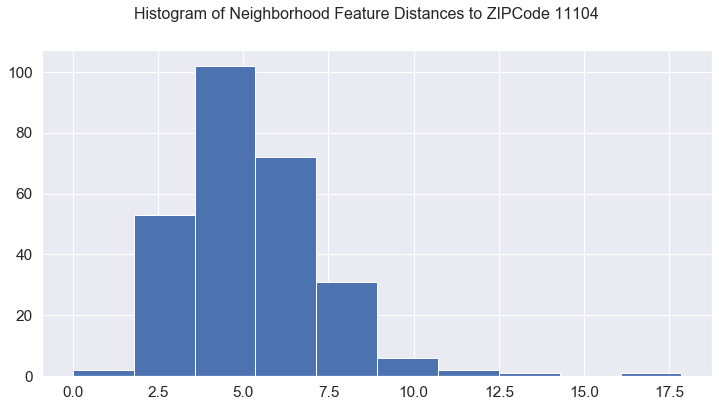

In [128]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
print('max distance: ', df_all['distance'].max())
print('min distance: ', df_all['distance'].min())
ax = plt.hist(df_all['distance'])
fig.suptitle('Histogram of Neighborhood Feature Distances to ZIPCode 11104', fontsize=16)

In [129]:
try:
    with open('all_geodata.pkl', 'rb') as handle:
        all_geodata_df = pickle.load(handle)
        print('all_geodata_df from filesystem')
except Exception as e: 
    print("Exception caught: {}".format(e))

map_data = pd.concat([df_all, all_geodata_df], axis=1, sort=False)
map_data.dropna(inplace=True)

all_geodata_df from filesystem


In [131]:
import folium
#from matplotlib import cm
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import branca
import branca.colormap as cm

color_map = cm.LinearColormap(colors=['lime','black'], vmin=0,vmax=10)

#color_map = cm.get_cmap('viridis', 12)
#color_map = cm.get_cmap('RdYlGn')
#color_map = cm.get_cmap('Greys')
latitude, longitude  = 43.718518, -79.464763 # center map in Toronto 
postal_zone_map = folium.Map(location=[latitude, longitude], zoom_start=11) 
for latitude, longitude, distance, label in zip(map_data['Latitude'], 
                                               map_data['Longitude'],
                                               map_data['distance'],
                                               map_data.index):
    folium.vector_layers.CircleMarker(
        [latitude, longitude],
        radius=7,
        color='black',
        #popup=label1 + '\n'+ label2,
        popup = label,
        
        fill_color=color_map(distance),
        fill_opacity=100,
        fill = True
    ).add_to(postal_zone_map)
postal_zone_map.add_child(color_map)
# display map

postal_zone_map.save('distance_map_limited_features.html')
postal_zone_map

## Results and Discussion<a name="results"></a>

Using data to make individual decisions is a clear growth opportunity for applications of data science.  In this example, analysis provided guidance in prioritizing neighborhoods to consider in relocating.  Clustering provided some feedback on the comparability of the two cities, New York and Toronto, under consideration, and also provided a set of potential candidates for further exploration.  The list of candidates provided by clustering proved too large, however, yeilding too many neighborhoods to adopt the list and realistically begin real world exploration.  

Using feature distances, we were able to develop an ordered set of candidate neighborhoods, and then visualize them to provide guidance in exploring the new city.  This approach creates a flexible, prioritized list of candidates that should greatly streamline the task of choosing a neighborhood in which to relocate.  

## Conclusions

Analysis of data from the FourSquare database allowed for some distinctions to be made between neighborhoods in New York City and Toronto.  The analysis was able to pinpoint a handful of neighborhoods that should be explored as potential sites for relocation.  Although the limitations in the dataset may have resulted in exagerating the distinctiveness of neighborhoods, the ablity to provide a clear starting point for starting a relocation search is clearly valuable.  

Using a data-driven approach to make an individual decision is labor intensive, and heavily dependent on the availability of high-quality data.  In the case of the neighborhood exploration, we found that the overall dataset provided little structure to create meaningful clusters of neighborhoods.  Understanding this limitation more thoroughly would help us to substitute or supplement the dataset with additional or changed features.  The goal for augmenting or changing the dataset would be to find data that provided stronger signals to differentiate one neighborhood from the others.  